## Introduction
Welcome everyone to Datameka's hackathon challenge on Singapore housing price prediction. This blog post introduces you to the baseline code covering 1)  preprocessing the raw dataset, 2) building simple predictive models, and 3) preparing a final submission file. Without further due, let's dive into the code.

Various CSV files are provided in this challenge. Before building a predictive model, it is required to preprocess each CSV file and merge them into a single CSV file. First, let us load all the provided CSV files into Panda Dataframes.

In [14]:
import re
import pandas as pd
from toolz import *
from toolz.curried import *

# paths to all the csvs files provided in the challenge.
trainPath   = "./raw/train.csv"
testPath    = "./raw/test.csv" 
microPath   = "./raw/properties.csv"
macrosPaths = ["./raw/cpi.csv", "./raw/interest.csv", "./raw/rentIndex.csv", "./raw/vacant.csv"]
geoPath     = "./raw/geo_attributes.csv"

# load the csvs into pandas's Dataframe.
## load train&test_keys that contain unique identifier for each observation
train_keys = pd.read_csv(trainPath).assign(train = 1)
test_keys  = pd.read_csv(testPath).assign(train = 0).assign(price = pd.NA)
keys       = pd.concat([train_keys, test_keys])
keys       = keys.rename(columns = {"contractDate" : "date"})

## merge key with micro to borrow the date information in key.
_micro = pd.read_csv(microPath)
micro  = pd.merge(_micro, keys, on = "property_key")

## load all the macro files
macros = []
for macrosPath in macrosPaths:
    df = pd.read_csv(macrosPath)
    df = df.rename(columns = {"Data Series" : "date"})
    macros.append(df)

# load geo
geo = pd.read_csv(geoPath)

Now let's define preprocessing functions for micro and macro data. For micro data, we perform two preprocessings: 1) merging rare floor units (high-story units) into one category and 2) categorizing the tenure column into binary (freehold|lease).

In [15]:
def preprocess_micro(micro):    
    """
    preprocess micro data properties.csv
    """
    def _floorRange(row, thresFloor = 41):
        """
        some floorRanges are too rare to be used as categorical variables
        Hence merging floorRage above the "thresFloor" into one.
        """
        floorRange = row["floorRange"]    
        if floorRange != "-":
            floorMin = int(re.search("(\d+)-", floorRange).groups()[0])
            if floorMin >= thresFloor:
                row["floorRange"] = f"{thresFloor}-99"    
        return row

    def _tenure(row):
        """
        some tenures are too rare to be used as variables.
        Hence simply making tenure feature to 1 if freehold else 0.
        """
        tenure = row["tenure"]    
        if tenure == "Freehold" : row["tenure"] = 1
        else                    : row["tenure"] = 0        
        return row
        
    micro = (micro
             .apply(_floorRange, axis = 1)
             .apply(_tenure, axis = 1))
    
    micro["date"] = pd.to_datetime(micro["date"])
    
    return micro

For macro data, some informations are available only in quaterly resolution, we need to re-format quaterly to monthly using simple linear interpolation.

In [16]:
def preprocess_macros(cpi, interest, rentIndex, vacant):
    """
    four files are considered as macro-related files :
        * cpi.csv
        * interest.csv
        * rentIndex.csv
        * vacant.csv
    """
    
    def yq2ym(df):
        """
        convert year-quater in string format to monthly period
        """
        
        # repeat the first row for desired interpolation result
        df = pd.concat([df.head(0), df])
        df.at[0, "date"] = "2023 1Q "
            
        df["date"] = (pd.to_datetime((df["date"]
                                      .str
                                      .replace(r"(\d+) (\d)Q ", r"\1-Q\2")))
                      .dt
                      .to_period('M'))        
        df = df.set_index("date").resample("M", convention = "end").interpolate("linear")        
        return df    

    def ym2ym(df):
        """
         convert year-month in string format to monthly period
        """
        df["date"] = (pd.to_datetime(df["date"], format = "%Y %b ")
                      .dt
                      .to_period('M'))
        return df
    
    def mergeDfs(dfs, on):        
        """
        join dataframes into one
        """
        # grab first dataframe
        all_merged = dfs[0]
        # loop through all but first data frame
        for to_merge in dfs[1:]:
            # result of merge replaces first or previously
            # merged data frame w/ all previous fields
            all_merged = pd.merge(all_merged, to_merge,
                                  how = 'inner',
                                  on  = on)
        return all_merged
    
    # apply appropriate date conversion function for each dataframe
    dfs = [ym2ym(cpi), ym2ym(interest), yq2ym(rentIndex), yq2ym(vacant)]
    
    # join all dataframs into one
    df = mergeDfs(dfs, on = "date")   
    # convert peroid[M] to datetime
    df["date"] = df["date"].dt.to_timestamp()    
    # shift month + 3 
    df["date"] = df["date"] + pd.DateOffset(months=+3)
    
    return df 

Now let's apply the two functions defined above to the micro and macro data.

In [17]:
micro = preprocess_micro(micro)
macro = preprocess_macros(*macros)

We merge the preprocessed micro and macro data. Also, we fill in the missing values generated from the merging process using simple mean imputation.

In [18]:
_merged = pd.merge(micro, macro, on = "date", how = "left")
merged  = pd.merge(_merged, geo, on = ["street", "project", "district"], how = "left")
merged  = merged.fillna(merged.mean())

train = merged[merged["train"] == 1]
test  = merged[merged["train"] == 0]

/home/jacob/.pyenv/versions/miniconda3-4.3.30/envs/miccai/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## Modeling
Now we are ready to define and train predictive models using the preprocessed data. We will be using 3 models: Linear Regression, LightGBM, and Neural Network with 2 hidden layers (512 neurons, 100 neurons). The models will commonly have 3 functions: 1) train, 2) predict, and 3) feature importance. The train function takes feature X and target Y to train the parameters in the model. The prediction function takes feature X and outputs predicted values YHat. Finally, the feature importance function outputs a dictionary that gives the relative importance of the input features to prediction.


In [19]:
import numpy as np

from sklearn.linear_model import LinearRegression   as _LR
from lightgbm import LGBMRegressor                  as _LGBM
from sklearn.neural_network import MLPRegressor     as _NN  

from matplotlib import pyplot as plt

In [20]:
class LR :
    def __init__(self, kwargs):        
        self.kwargs = kwargs
        
    def train(self, X, y):     
        self.X = X
        self.fitted = _LR(**self.kwargs).fit(X, y)
        
    def predict(self, X):                
        return self.fitted.predict(X)
    
    def feature_importances(self):        
        return dict(zip(self.X.columns, map(abs)(self.fitted.coef_)))
    
class LGBM :
    def __init__(self, kwargs):        
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _LGBM(**self.kwargs).fit(X, y)
        
    def predict(self, X):                
        return self.fitted.predict(X)
    
    def feature_importances(self):
        return dict(zip(self.X.columns, self.fitted.feature_importances_))
        
class NN :
    def __init__(self, kwargs):        
        self.kwargs = kwargs
        
    def train(self, X, y):
        self.X = X
        self.fitted = _NN(**self.kwargs).fit(X, y)
        
    def predict(self, X):                
        return self.fitted.predict(X)
    
    def feature_importances(self):
        # not implemented could try implementing using Shapley
        self.feature_importances = dict(zip(self.X.columns, np.zeros(len(self.X.columns))))


Also, we create a metaclass called Models that gives extra functionality (such as generating RMSE metric, error plotting, and feature importance in a barplot) to the model classes defined above.

In [21]:
class Models :
    
    def __init__(self, modelArgs):
                
        self.modelArgs = modelArgs 
        self.model = {"LR"  : LR  ,
                      "LGBM": LGBM,
                      "NN"  : NN}[self.modelArgs.modelName](self.modelArgs.kwargs)
        
    def train (self, X, y):
        print(f"training {self.modelArgs.modelName} ...")        
        self.model.train(X, y)
        print(f"done")
            
    def predict(self, X):
        print(f"predicting {self.modelArgs.modelName} ...")
        yHat = self.model.predict(X)
        print(f"done")
        return yHat
        
    def evaluate(self, X, y):
        computeRMSE = lambda y, yHat : (((np.array(y) - np.array(yHat))**2).mean())**0.5
        
        yHat = self.predict(X)
        mse = computeRMSE(y, yHat)
        
        plt.figure().set_figwidth(30)
        plt.plot(y- yHat, "-b", label="true", alpha = 0.3)
        plt.title(f"model:({self.modelArgs.modelName}) : MSE: {mse}" )        
        plt.xlabel("observation")
        plt.ylabel("price")
        plt.show()
        return mse
    
    def interpret(self):
        importances = self.model.feature_importances()
        importances = dict(sorted(importances.items(), key=lambda kv: kv[1], reverse = True))
        
        plt.figure().set_figwidth(30)
        plt.bar(importances.keys(),
                importances.values())
        plt.title(f"model:({self.modelArgs.__name__})" )        
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.xticks(rotation=-45, ha="left")        
        plt.show()        
        return importances

Also, we define a function that converts selected variables to one-hot encoding.

In [22]:
def toOneHot(df, inputTypes):
    df = df[inputTypes.keys()]
    df.astype(inputTypes)
    for columnName, inputType in inputTypes.items():
        if inputType == str:
            oneHot = pd.get_dummies(df[columnName], prefix = columnName)            
            df = pd.concat([df,oneHot], axis=1).drop([columnName], axis=1)
    return df

Let's now apply all the functions and classes defined above to train and get test results. First we set the arguments for the model we use and the set of variables to be used in modelling

In [23]:
class LRArgs:
    modelName = "LR"
    kwargs = {}        

class LGBMArgs:
    modelName = "LGBM"
    kwargs    = {"boosting_type" :'gbdt',
                 "objective"     :'regression',
                 "learning_rate" : 0.1}
class NNArgs:
    modelName = "NN"
    kwargs = {"hidden_layer_sizes" : (512,100),
              "learning_rate_init" : 0.001,
              "max_iter"           : 500}

class Args :
    inputVars = {"price"                 : float, # to predict
    
                 "area"                  : float,
                 "floorRange"            : str,
                 "propertyType"          : str,
                 "district"              : str,
                 "typeOfArea"            : str,
                 "tenure"                : float,
                 "marketSegment"         : str,
                 "lat"                   : float,
                 "lng"                   : float,
                 "num_schools_1km"       : float,
                 "num_supermarkets_500m" : float,
                 "num_mrt_stations_500m" : float,
                 "CPI"                   : float,
                 "InterestRate"          : float,
                 "RentIndex"             : float,
                 "Available"             : float,
                 "Vacant"                : float,
                 
                "train"                  : float}

    modelArgs = {"LR"   : LRArgs,
                 "LGBM" : LGBMArgs,
                 "NN"   : NNArgs}["LGBM"] # default is LGBM

Let's start converting categrical variables into one-hot encoding and split the dataframe after into train & test after that.

In [24]:
df = pd.concat([train, test])    
df = toOneHot(df, Args.inputVars) 
dfTrain = df[df["train"] == 1].drop("train", axis = 1)
dfTest  = df[df["train"] == 0].drop("train", axis = 1)

Here we define the model using the arugments above. After we train & test the model with the preprocessed dataset

training LGBM ...
done
predicting LGBM ...
done


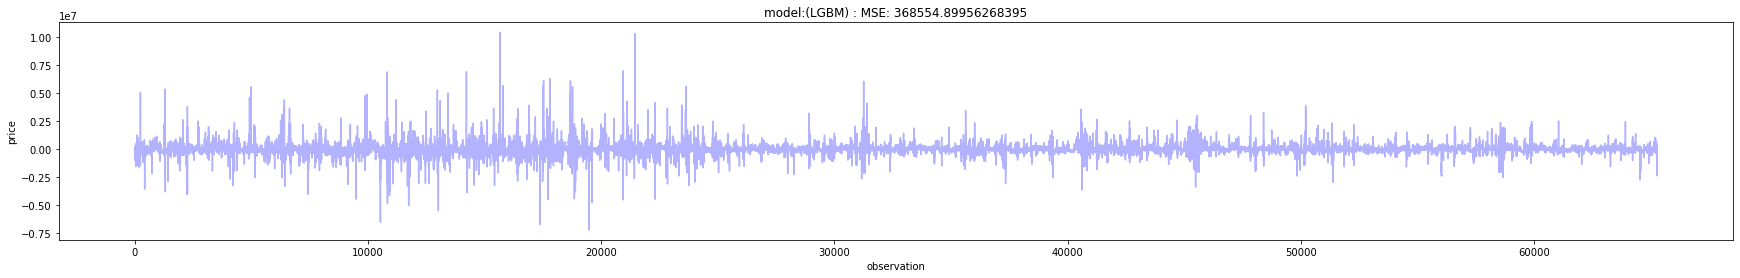

predicting LGBM ...
done


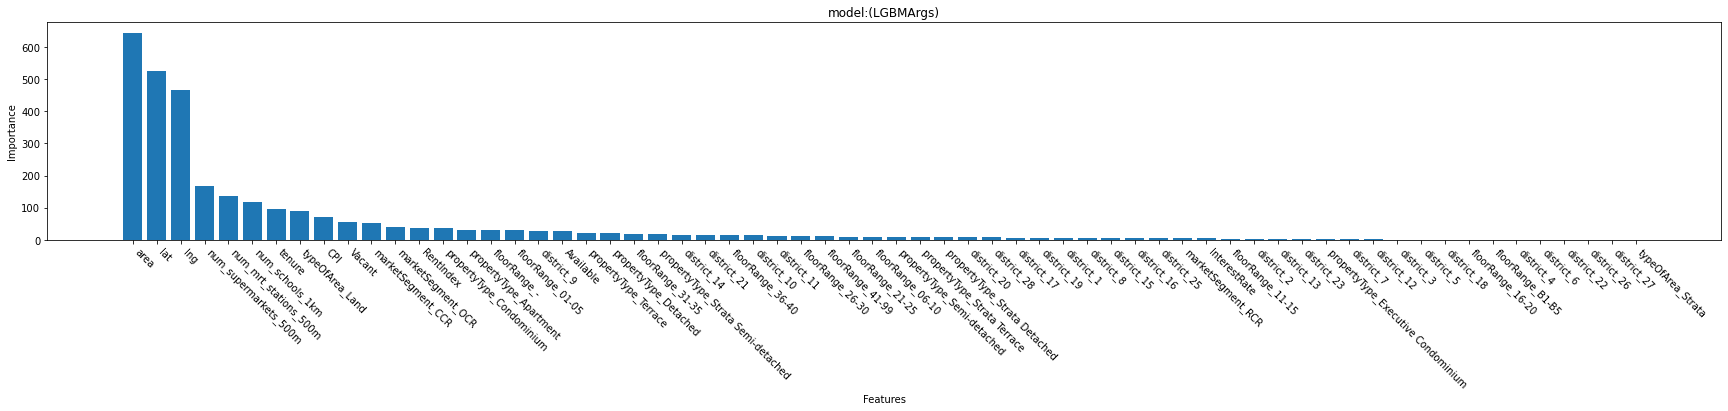

{'area': 644,
 'lat': 524,
 'lng': 466,
 'num_supermarkets_500m': 167,
 'num_mrt_stations_500m': 136,
 'num_schools_1km': 117,
 'tenure': 97,
 'typeOfArea_Land': 89,
 'CPI': 72,
 'Vacant': 56,
 'marketSegment_CCR': 51,
 'marketSegment_OCR': 41,
 'RentIndex': 38,
 'propertyType_Condominium': 36,
 'propertyType_Apartment': 32,
 'floorRange_-': 30,
 'floorRange_01-05': 30,
 'district_9': 29,
 'Available': 26,
 'propertyType_Terrace': 21,
 'propertyType_Detached': 20,
 'floorRange_31-35': 19,
 'propertyType_Strata Semi-detached': 18,
 'district_14': 16,
 'district_21': 16,
 'floorRange_36-40': 14,
 'district_10': 14,
 'district_11': 13,
 'floorRange_26-30': 12,
 'floorRange_41-99': 12,
 'floorRange_21-25': 10,
 'floorRange_06-10': 9,
 'propertyType_Semi-detached': 9,
 'propertyType_Strata Terrace': 9,
 'propertyType_Strata Detached': 8,
 'district_20': 8,
 'district_28': 8,
 'district_17': 7,
 'district_19': 7,
 'district_1': 6,
 'district_8': 6,
 'district_15': 6,
 'district_16': 6,
 'dis

In [25]:
model = Models(Args.modelArgs)

model.train(dfTrain.loc[:, dfTrain.columns != 'price'],
            dfTrain["price"])    

model.evaluate(dfTrain.loc[:, dfTrain.columns != 'price'],
               dfTrain["price"])

preds = model.predict(dfTest.loc[:, dfTrain.columns != 'price'])

model.interpret()

In [26]:
predDf = pd.DataFrame({"property_key" : test["property_key"],
                       "contractDate" : test["date"],
                       "prediction"   : list(preds)})
predDf.to_csv("submission_baseline_lgbm3.csv", index = False)